In [4]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, KFold
housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 5

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=500, n_features=1, noise=10, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def make_dataset(X_data,y_data,k):
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,y_train,X_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double))
dataset = make_dataset(X_train2, X_test2, k)
print(dataset)
    

<FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>



Original:  24.40009253339177 
Predicted:  16.27564829500003 
Tested: 16.275131203314153 

Train_MeanSquaredError:  104.09379
Train_MeanAbsoluteError:  7.91943
Train_MeanSquaredLogError:  0.3345271
--------------------------------------------------------
Test_MeanSquaredError:  217.98
Train_MeanAbsoluteError:  11.804039
Test_MeanSquaredLogError:  0.16551578


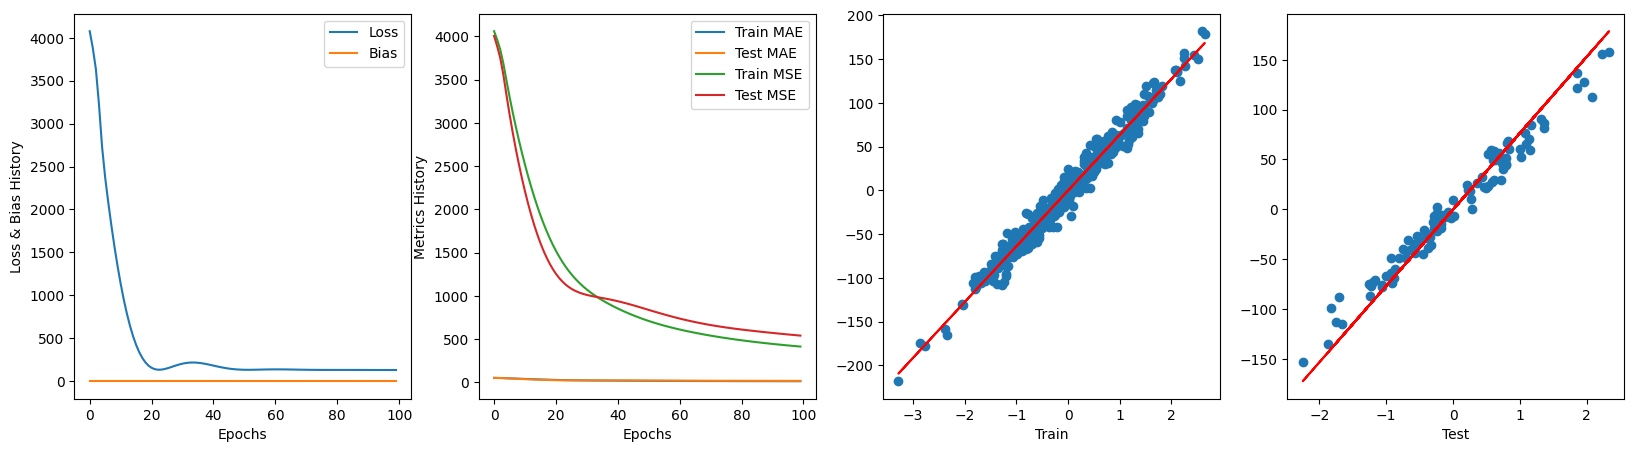

In [5]:
class Layer(tf.Module):
    def __init__(self, activation=tf.identity):
        self.activation = activation
        self.build = False
        self.normalized = False

    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    @tf.function
    def __call__(self, X):
        if not self.build:
            n_samples, n_features = X.shape
            self.weights = tf.Variable(self.xavier_init(shape=(n_features, n_samples)), name="Weights", dtype=tf.double, trainable=True, )
            self.bias = tf.Variable(tf.zeros(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.matmul(X, self.weights), self.bias)

        #print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z)

    

class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, X, X_test, y, y_test, lr=0.001, epochs=10):
        self.layers = layers
        self.lr = lr
        self.epochs = epochs
        self.X = X 
        self.XN = normalize_dataset(X)
        self.XN_test = normalize_dataset(X_test)
        self.y = y
        self.y_test = y_test
        self.X_test = X_test
        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=1000000, decay_rate=0.96, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.train_mse = tf.keras.metrics.MeanSquaredError()
        self.train_mae = tf.keras.metrics.MeanAbsoluteError()
        self.train_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.test_mse = tf.keras.metrics.MeanSquaredError()
        self.test_mae = tf.keras.metrics.MeanAbsoluteError()
        self.test_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.regularizer = tf.keras.layers.ActivityRegularization()
        self.loss_history = [e for e in range(epochs)]
        self.bias_history = [e for e in range(epochs)]
        self.mae_train_error_history = [e for e in range(epochs)]
        self.mse_train_error_history = [e for e in range(epochs)]
        self.mae_test_error_history = [e for e in range(epochs)]
        self.mse_test_error_history = [e for e in range(epochs)]
        self.predicted_train_history = [[ i for i in range(self.y.shape[0]) ] for e in range(epochs)]

    def calc_history(self, e, loss):
        self.train_mae.update_state(self.y, self.predicted)
        self.train_mse.update_state(self.y, self.predicted)
        self.test_mae.update_state(self.y_test, self.predicted_test)
        self.test_mse.update_state(self.y_test, self.predicted_test)
        self.bias_history[e] = self.bias
        self.loss_history[e] = loss.numpy()
        self.predicted_train_history[e] = self.predicted
        self.mae_train_error_history[e] = self.train_mae.result().numpy()
        self.mse_train_error_history[e] = self.train_mse.result().numpy()
        self.mae_test_error_history[e] = self.test_mae.result().numpy()
        self.mse_test_error_history[e] = self.test_mse.result().numpy()
    
    @tf.function
    def lasso(self):
        lassos = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            lassos[w] = tf.reduce_sum(tf.norm(self.layers[w].weights))
        return tf.reduce_mean(lassos)

    @tf.function
    def ridge(self):
        ridges = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            ridges[w] = tf.reduce_sum(tf.square(tf.norm(self.layers[w].weights)))
        return tf.reduce_mean(ridges)

    @tf.function(reduce_retracing=True)
    def train_accuracy_rrsse(self, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, self.y))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(self.y), predicted)))))
            )), predicted.shape[0]
        )

    @tf.function(reduce_retracing=True)
    def loss(self, predicted):
        return tf.add(tf.losses.MSE(self.y, predicted), self.lasso())

    @tf.function(reduce_retracing=True)
    def calc_metrics(self):
        self.train_mse.reset_state()
        self.train_mae.reset_state()
        self.test_mse.reset_state()
        self.test_mae.reset_state()
        self.train_accuracy.update_state(self.y, self.predicted)
        self.train_mse.update_state(self.y, self.predicted)
        self.train_mae.update_state(self.y, self.predicted)
        self.test_accuracy.update_state(self.y_test, self.predicted_test)
        self.test_mse.update_state(self.y_test, self.predicted_test)
        self.test_mae.update_state(self.y_test, self.predicted_test)

    @tf.function(reduce_retracing=True)
    def train_step(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def _predict_train(self, X, weights):
        compressed_weights = tf.reduce_mean(tf.subtract(tf.multiply(X, weights), self.bias), axis=1)
        return tf.reduce_mean(tf.add(tf.multiply(tf.transpose(X), compressed_weights), self.bias), axis=1)

    def predict_test(self):
        self.predicted_test = tf.reduce_mean(tf.add(tf.multiply(self.X_test, self.compressed_weights), self.bias), axis=1)

    def predict(self, x):
        return tf.reduce_mean(tf.add(tf.multiply(x, self.compressed_weights), self.bias))

    def run(self):
        self.weights = model.train_step(self.XN)
        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]

        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.weights = self.train_step(self.XN)
                self.bias = self.layers[len(self.layers)-1].bias
                self.flatten_weights = tf.reduce_mean(self.weights, axis=0)
                self.predicted = self._predict_train(tf.transpose(self.X), self.flatten_weights)
                
                loss = tf.nn.scale_regularization_loss(self.loss(self.predicted)) 
                
                self.compressed_weights = tf.reduce_mean(tf.add(tf.multiply(tf.transpose(self.XN), tf.reduce_mean(self.weights, axis=0)), self.bias), axis=1)
                self.predict_test()

                self.calc_history(e, loss)

            grads = tape.gradient(loss, self.vars)
            self.optimizer.apply_gradients(zip(grads, self.vars)) 

model = MLPLinearRegressor([
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.sigmoid),
    Layer()
], X_train2, X_test2, tf.squeeze(y_train2), tf.squeeze(y_test2), lr=0.01, epochs=100)


model.run()
print("\nOriginal: ", y_test2[0], "\nPredicted: ", model.predict(X_test2[0]).numpy(), "\nTested:", model.predicted_test[0].numpy(), "\n")
model.calc_metrics()


print("Train_MeanSquaredError: ", model.train_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.train_mae.result().numpy())
print("Train_MeanSquaredLogError: ", model.train_accuracy.result().numpy())
print('--------------------------------------------------------')
print("Test_MeanSquaredError: ", model.test_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.test_mae.result().numpy())
print("Test_MeanSquaredLogError: ", model.test_accuracy.result().numpy())

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot([e for e in range(model.epochs)], model.loss_history, label="Loss")
ax[0].plot([e for e in range(model.epochs)], tf.square(model.bias_history).numpy(), label="Bias")
ax[0].set_ylabel('Loss & Bias History')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot([e for e in range(model.epochs)], model.mae_train_error_history, label="Train MAE")
ax[1].plot([e for e in range(model.epochs)], model.mae_test_error_history, label="Test MAE")
ax[1].plot([e for e in range(model.epochs)], model.mse_train_error_history, label="Train MSE")
ax[1].plot([e for e in range(model.epochs)], model.mse_test_error_history, label="Test MSE")
ax[1].set_ylabel('Metrics History')
ax[1].set_xlabel('Epochs')
ax[1].legend()

ax[2].scatter(X_train2[:, -1], y_train2[:])
ax[2].plot(X_train2[:, -1], model.predicted[:], color='r')
#ax[2].set_ylim([-200, 200])
#ax[2].set_xlim(-3,3)
ax[2].set_xlabel("Train")

ax[3].scatter(X_test2[:, -1], y_test2[:])
ax[3].plot(X_test2[:, -1], model.predicted_test[:], color='r')
#ax[3].set_ylim([-200, 200])
#ax[3].set_xlim(-3,3)
ax[3].set_xlabel("Test")
"""
fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(X_train2[:, 0], X_train2[:, 1], y_train2[:])
ax3d.plot(X_train2[:, 0], X_train2[:, 1], model.predicted[:])"""


plt.show()

